
--- Initial Data Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 262585 entries, 0 to 262584
Data columns (total 22 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   ID                    262585 non-null  int64  
 1   Case Number           262585 non-null  object 
 2   Date                  262585 non-null  object 
 3   Block                 262585 non-null  object 
 4   IUCR                  262585 non-null  object 
 5   Primary Type          262585 non-null  object 
 6   Description           262585 non-null  object 
 7   Location Description  261178 non-null  object 
 8   Arrest                262585 non-null  bool   
 9   Domestic              262585 non-null  bool   
 10  Beat                  262585 non-null  int64  
 11  District              262585 non-null  int64  
 12  Ward                  262582 non-null  float64
 13  Community Area        262585 non-null  int64  
 14  FBI Code              262

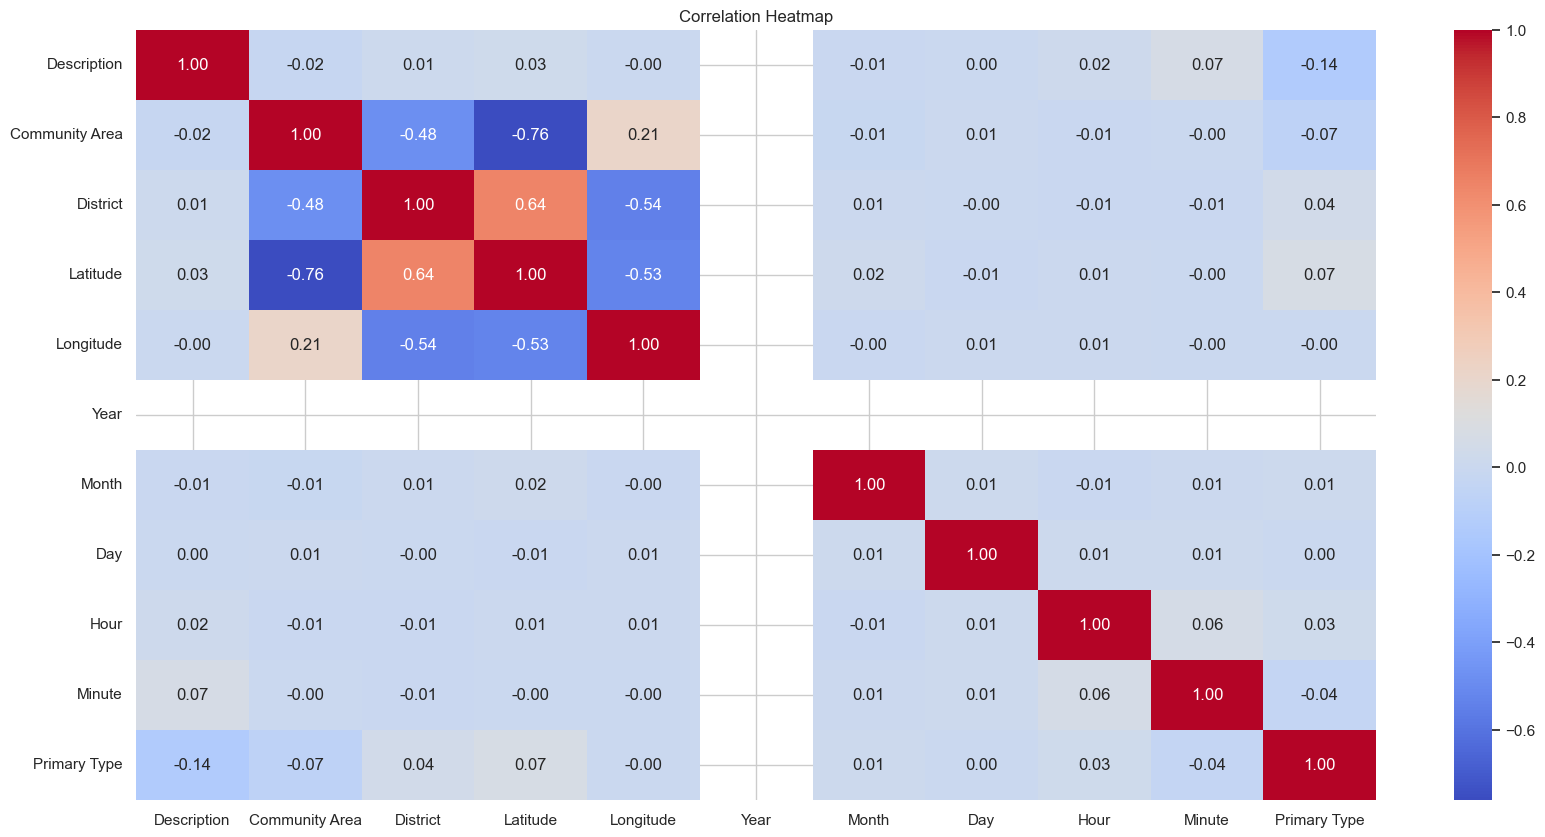

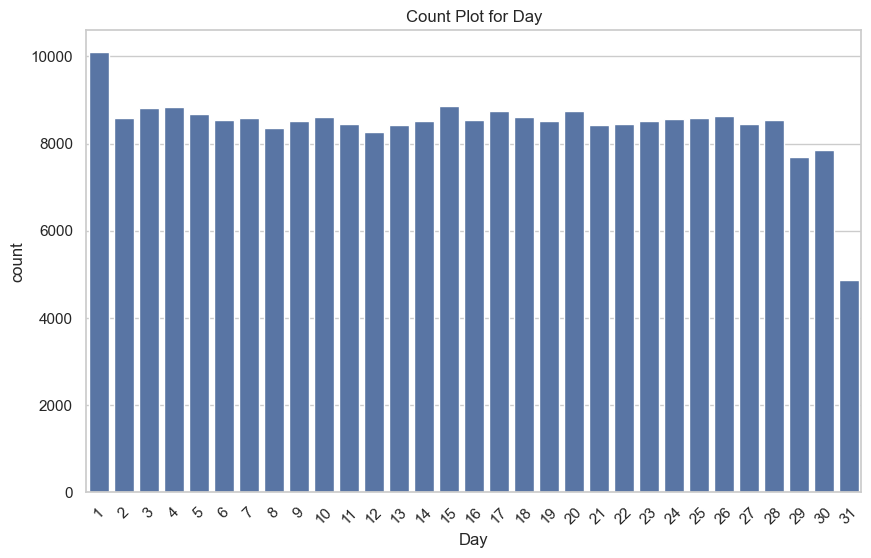

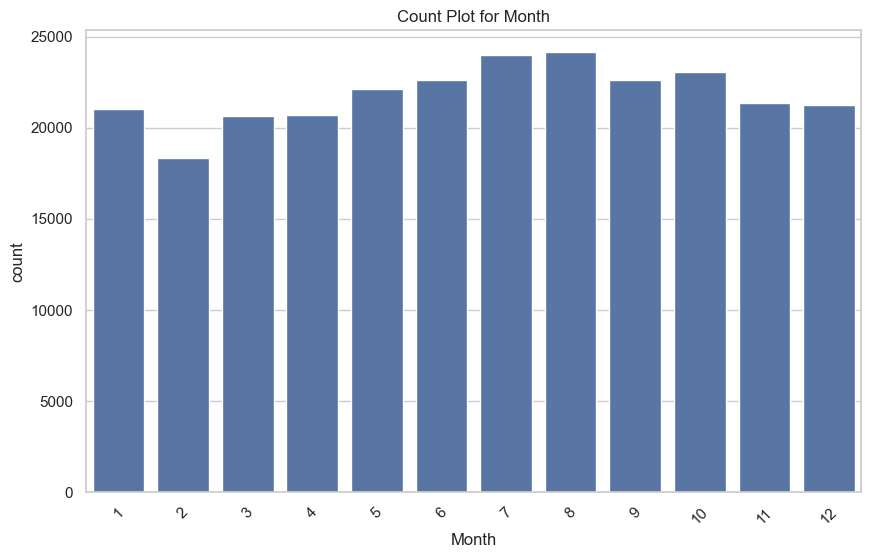

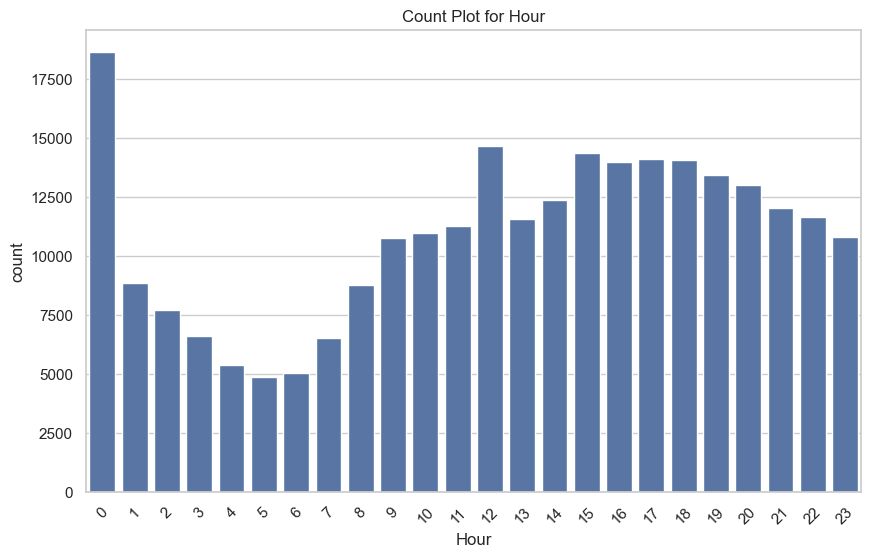

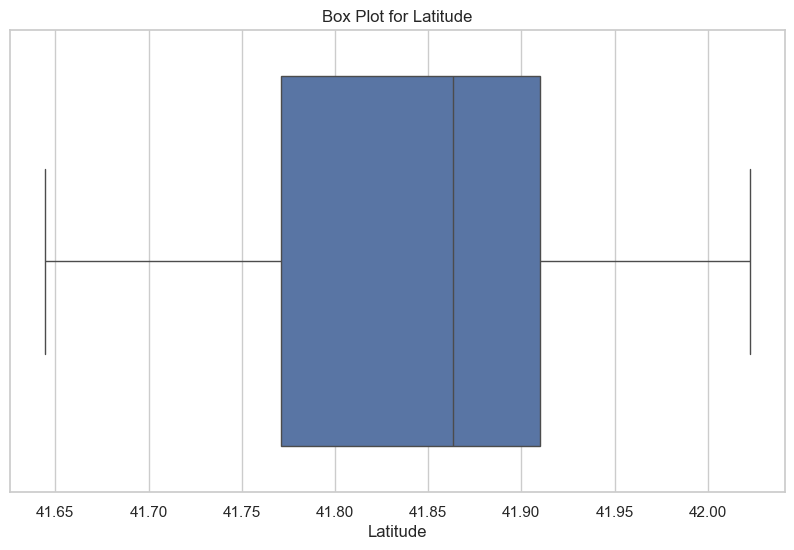

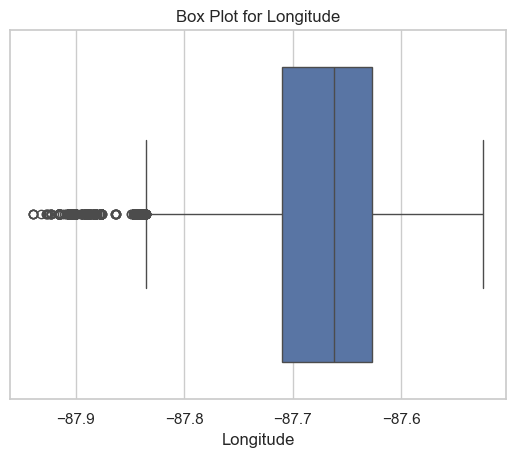


--- Removing Outliers from Longitude ---

Logistic Regression Results:

--- Training and Evaluating Model ---
Accuracy: 0.33
Precision (weighted): 0.23
Recall (weighted): 0.33
F1 Score (weighted): 0.24

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       153
           1       0.00      0.00      0.00      6756
           2       0.27      0.34      0.30     13181
           3       0.00      0.00      0.00      2240
           4       0.00      0.00      0.00        51
           5       0.54      0.98      0.70      8985
           6       0.00      0.00      0.00       485
           7       0.00      0.00      0.00      1385
           8       0.50      0.00      0.00      5013
           9       0.00      0.00      0.00         4
          10       0.00      0.00      0.00       188
          11       0.00      0.00      0.00         2
          12       0.00      0.00      0.00       175
          13    

In [16]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder # package needed to be installed separately. Was not present in e4_trainor_python_course virtual environment.
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import xgboost as xgb  

"""
Versions of each imported library 

Name: pandas
Version: 2.1.0

Name: matplotlib
Version: 3.9.2

Name: seaborn
Version: 0.13.2

Name: scikit-learn
Version: 1.5.1

Name: xgboost
Version: 2.0.0

"""

# Function to load and inspect the data
def load_data(filepath):
    """
    Load the dataset and display basic info.
    """
    data = pd.read_csv(filepath)
    print("\n--- Initial Data Info ---")
    data.info()
    print("\nSample Data:")
    print(data.head())
     # Print dataset shape
    print(f"\nData Shape: {data.shape}")
    # Print missing value summary
    print("\nMissing values in the dataset:")
    print(data.isna().sum()) 
    # Example to check class distribution
    class_distribution = data["Primary Type"].value_counts(normalize=True)  # Percentage of each class
    print("Class Distribution:\n", class_distribution)

    return data

# Function to preprocess the dataset
def preprocess_data(data):
    """
    Select relevant columns, handle missing values, and encode categorical features.
    """
    print("\n--- Preprocessing Data ---")

    # Select relevant columns
    data = data[["Date", "Primary Type", "Description", "Community Area", "District", "Latitude", "Longitude"]].copy()

    # Convert 'Date' column to datetime and extract components
    data['Date'] = pd.to_datetime(data['Date'])
    data['Year'] = data['Date'].dt.year
    data['Month'] = data['Date'].dt.month
    data['Day'] = data['Date'].dt.day
    data['Hour'] = data['Date'].dt.hour
    data['Minute'] = data['Date'].dt.minute

    # Drop the 'Date' column
    data.drop(columns=['Date'], inplace=True)

    # Handle missing values
    data = data.dropna().reset_index(drop=True)

    # Encode categorical variables
    le = LabelEncoder()
    data['Primary Type'] = le.fit_transform(data['Primary Type'])
    data['Description'] = le.fit_transform(data['Description'])

    print("Data after preprocessing:")
    print(data.head())
    return data

def visualize_data(data, features, target):
    """
    Plot correlation heatmap and count plots for selected features.
    """
    print("\n--- Visualizing Data ---")

    # Correlation heatmap
    correlation_matrix = data[features + [target]].corr()
    plt.figure(figsize=(20, 10))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title('Correlation Heatmap')
    plt.show()

    # Count plots for time-based columns
    for column in ['Day', 'Month', 'Hour']:
        plt.figure(figsize=(10, 6))
        sns.countplot(x=column, data=data)
        plt.title(f'Count Plot for {column}')
        plt.xticks(rotation=45)
        plt.show()
        
    columns = ['Latitude', 'Longitude']
    # Create a box plot for all columns
    sns.set_theme(style="whitegrid")  
    plt.figure(figsize=(10, 6))  
    # Loop through each column and create a box plot
    for column in columns:
        sns.boxplot(x=data[column])
        plt.title(f'Box Plot for {column}')
        plt.show()

# Function to remove outliers
def remove_outliers(data, column):
    """
    Remove outliers from a specific column using the IQR method.
    """
    print(f"\n--- Removing Outliers from {column} ---")
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return data[(data[column] >= lower_bound) & (data[column] <= upper_bound)].reset_index(drop=True)

# Function to train and evaluate a model
def train_evaluate_model(model, X_train, X_test, y_train, y_test):
    """
    Train a model, make predictions, and evaluate performance.
    """
    print("\n--- Training and Evaluating Model ---")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    class_report = classification_report(y_test, y_pred)

    print(f"Accuracy: {accuracy:.2f}")
    print(f"Precision (weighted): {precision:.2f}")
    print(f"Recall (weighted): {recall:.2f}")
    print(f"F1 Score (weighted): {f1:.2f}")
    print(f"\nClassification Report:\n{class_report}")

# Main script
if __name__ == "__main__":
    filepath = "Crimes_-_2023_20241025.csv"

    # Step 1: Load and preprocess the data
    data = load_data(filepath)
    data = preprocess_data(data)

    # Step 2: Feature and target selection
    features = data.drop(columns=["Primary Type"]).columns.tolist()
    target = "Primary Type"

    # Step 3: Visualize data
    visualize_data(data, features, target)

    # Step 4: Handle outliers
    data = remove_outliers(data, 'Longitude')

    # Step 5: Split data into training and testing sets
    X = data.drop(columns=[target])
    y = data[target]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

    # Step 6: Train and evaluate multiple models
    models = {
        "Logistic Regression": LogisticRegression(multi_class='multinomial', solver='sag', penalty='l2', C=1),
        "Naive Bayes": GaussianNB(),
        "K-Nearest Neighbors": KNeighborsClassifier(n_neighbors=5),
        "Random Forest": RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42),
        "XGBoost": xgb.XGBClassifier(eval_metric='mlogloss', use_label_encoder=False)
    }

    for name, model in models.items():
        print(f"\n{name} Results:")
        train_evaluate_model(model, X_train, X_test, y_train, y_test)
